In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
tweets=pd.read_csv("twitter_train.csv")

In [7]:
tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [9]:
tweets.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [10]:
tweets['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
5        [2/2] huge fan fare and big talking before the...
6         @user camping tomorrow @user @user @user @use...
7        the next school year is the year for exams.ð...
8        we won!!! love the land!!! #allin #cavs #champ...
9         @user @user welcome here !  i'm   it's so #gr...
10        â #ireland consumer price index (mom) climb...
11       we are so selfish. #orlando #standwithorlando ...
12       i get to see my daddy today!!   #80days #getti...
13       @user #cnn calls #michigan middle school 'buil...
14       no comment!  in #australia   #opkillingbay #se...
15       ouch...junior is angryð#got7 #junior #yugyo...
16       i am thankful for having a paner. #thankful #p.

In [11]:
tweets.drop(['id'], axis=1, inplace=True)
tweets.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


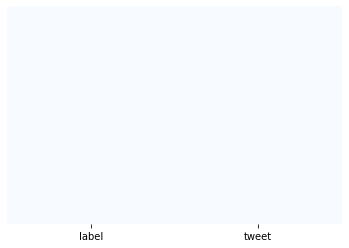

In [12]:
 sns.heatmap(tweets.isnull(), yticklabels = False, cbar = False, cmap="Blues")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002DD0CBB39E8>]],
      dtype=object)

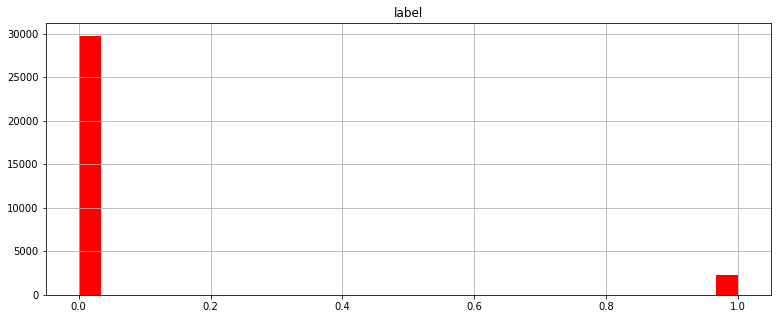

In [13]:
tweets.hist(bins = 30, figsize = (13,5), color = 'r')

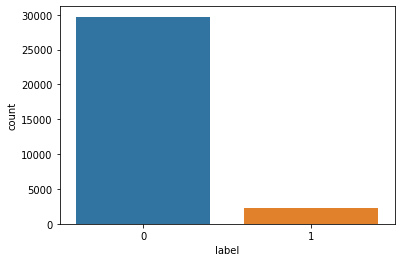

In [14]:
sns.countplot(x="label", data=tweets)

In [15]:
length=tweets['tweet'].apply(len)

In [16]:
tweets['length']=length

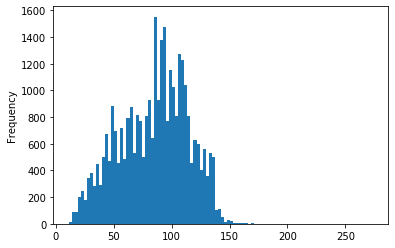

In [17]:
tweets['length'].plot(bins=100, kind='hist') 

In [18]:
tweets.describe()

,label,length
count,31962.000000,31962.000000
mean,0.070146,84.739628
std,0.255397,29.455749
min,0.000000,11.000000
25%,0.000000,63.000000
50%,0.000000,88.000000
75%,0.000000,108.000000
max,1.000000,274.000000


In [19]:
tweets[tweets['length']==int(length.mean())]['tweet'].iloc[0]

'my mom shares the same bihday as @user   bihday snake! see you this weekend ð\x9f\x99\x8cð\x9f\x8f¼'

In [20]:
positive=tweets[tweets['label']==0]
negative=tweets[tweets['label']==1]

In [21]:
sentences=tweets['tweet'].tolist()

In [22]:
all_sentences=" ".join(sentences)

In [23]:
!pip install WordCloud

In [24]:
from wordcloud import WordCloud

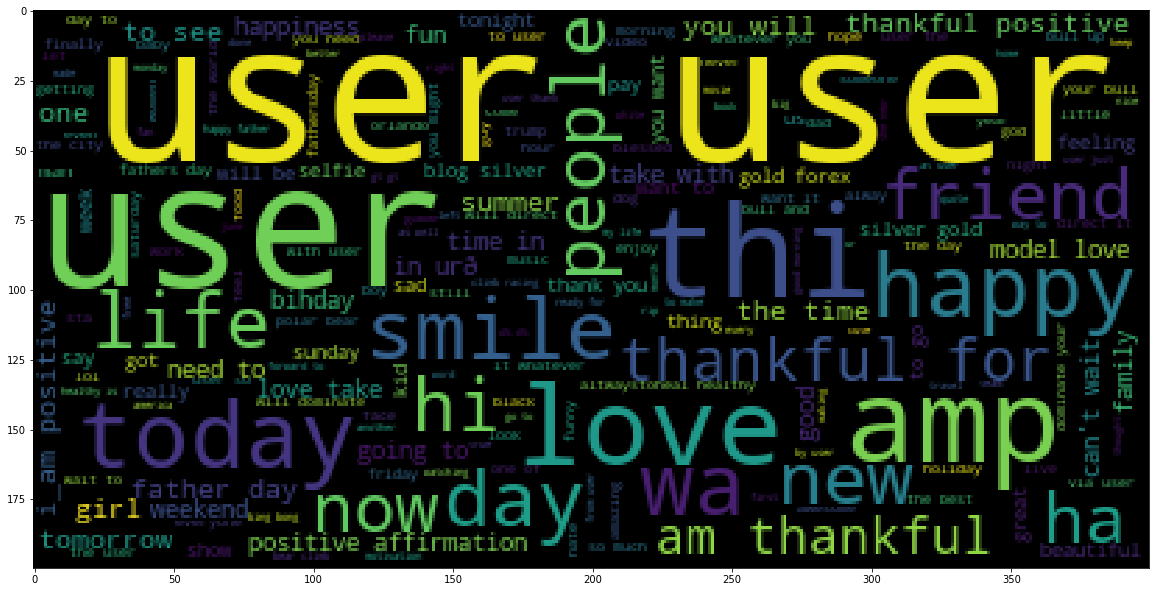

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(all_sentences))

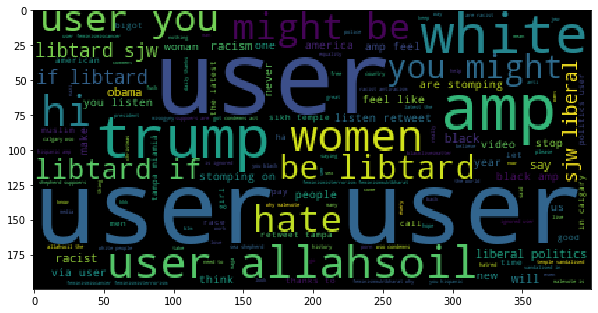

In [26]:
neglist=negative['tweet'].tolist()
negative_sentences=" ".join(neglist)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(negative_sentences))

In [47]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [48]:
import nltk

In [49]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
from nltk.corpus import stopwords
stpwrds= stopwords.words('english')

In [69]:
def cleaning(text):
    sentences_without_punc_as_chars=[char for char in text if char not in string.punctuation]
    sentences_without_punc="".join(sentences_without_punc_as_chars)
    sentences_without_punc_as_words=sentences_without_punc.split(" ")
    sentences_without_punc_as_words_no_stopwords=[wrd for wrd in sentences_without_punc_as_words if wrd.lower() not in stpwrds]
    sentences_without_punc_no_stopwords=[" ".join(sentences_without_punc_as_words_no_stopwords)]
    return sentences_without_punc_no_stopwords

tweets_clean['tweet']=tweets['tweet'].apply(cleaning)

In [70]:
tweets_clean.head()

0    [ user father dysfunctional selfish drags kids...
1    [user user thanks lyft credit cant use cause d...
2                                   [  bihday majesty]
3    [model   love u take u time urð± ððð...
4                  [ factsguide society    motivation]
Name: tweet, dtype: object

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer=cleaning)
tweetscv=vectorizer.fit_transform(tweets['tweet'])
print(vectorizer.get_feature_names())

['', '  ', '   ', '     link bio  mind body spirit personaldevelopmentâ\x80¦ ', '     reactions  happy reactions  ign live e3 2016 ', '     tkharbich illustration aminlazir suppoaist drawing adobe ', '    ashamed florida pulse gay club attacked orlando  least 20 dead  bbc news ', '    buraa dhin ', '    conjure smile today', '    dont remember  nyc somewhere ', '    feelgood summer ', '    friday beat instrumental wonder frontier', '    mclean virginia ', '    really comfoable  comment ð\x9f\x91\x87ð\x9f\x91\x87ð\x9f\x91\x87ð\x9f\x91\x87 ', '   5000 pigs burn alive saskatchewan barn fire video ', '   6step guide learning work anger mindfully empowering courageous awesome ', '   90th bihday majesty queen queen elizabeth', '   american kills taiwan couroom drug conviction ', '   attending user user', '   bangkok thailand ', '   bees knees ', '   bihday 296 44 time gone xx', '   bihday weekend  even better  xx ', '   bloggers happiness', '   borrowdale brooke harare zimbabwe ', '   cant w

In [81]:
tweetscv.shape

(31962, 29467)